# POD-DL-ROMs for the resolution of Hemodynamic PDEs

---
## 1 Data Preparation


#### Import useful libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import vtkmodules.all as vtk
from vtkmodules.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import meshio
from scipy.spatial.distance import cdist
from torchvision import datasets, transforms
import random

In [2]:
#Directory containing data
DATASET_PATH = r'\Users\enzos\Desktop\ml-project-2-ita-temp\dataset'

In [3]:
def set_seed(seed):
    """Set the seed for reproducibility

    Args:
        seed: int representing the chosen seed
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Fix the seed
set_seed(50)

In [4]:
#Choose the device to use

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Tou are currently using ", device)

Tou are currently using  cuda


#### Import and Preprocess Data

In [5]:
fields = {'velocity', 'pressure'}

basis_space, sv_space, Nh_space, nmodes_space = dict(), dict(), dict(), dict()
basis_time, sv_time, Nh_time, nmodes_time = dict(), dict(), dict(), dict()
nmodes = dict()
for field in fields:
    basis_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_basis.npy'))  # spatial basis
    sv_space[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'space_sv.npy'))  # singular values in space
    Nh_space[field], nmodes_space[field] = basis_space[field].shape  # number of FOM and ROM unknowns in space
    basis_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_basis.npy'))  # temporal basis
    sv_time[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'time_sv.npy'))  # singular values in time
    Nh_time[field], nmodes_time[field] = basis_time[field].shape  # number of FOM and ROM unknowns in time
    nmodes[field] = nmodes_space[field] * nmodes_time[field]  # total dimension of the reduced basis

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
N_supr_space = basis_space['pressure'].shape[1] + 66  # number of extra bases in space for the velocity
N_supr_time = 5  # number of extra bases in time for the velocity

# STORE ORIGINAL NUMBER OF VELOCITY MODES IN THE DICTIONARY
nmodes_space['velocity_full'] = nmodes_space['velocity']
nmodes_time['velocity_full'] = nmodes_time['velocity']
nmodes['velocity_full'] = nmodes['velocity']

# UPDATE THE NUMBER OF VELOCITY MODES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
nmodes_space['velocity'] -= N_supr_space
nmodes_time['velocity'] -= N_supr_time
nmodes['velocity'] = nmodes_space['velocity'] * nmodes_time['velocity']

# UPDATE VELOCITY BASES TO ACCOUNT FOR SUPREMIZERS AND STABILIZERS
basis_space['velocity'] = basis_space['velocity'][:, :nmodes_space['velocity']]
basis_time['velocity'] = basis_time['velocity'][:, :nmodes_time['velocity']]

# LOAD NORMED BASIS MATRICES IN SPACE (needed for projections)
basis_space_normed = dict()
#norm = dict()
for field in fields:
    basis_space_normed[field] = np.load(os.path.join(DATASET_PATH, 'basis', field, 'basis_space_normed.npy'))

#Functions to project to and espand with the POD spatial and temporal basis
def project(sol, normed_basis_space, basis_time):
    """ Project a full-order solution in space-time."""
    return (normed_basis_space.T.dot(sol)).dot(basis_time) # !! REMARK: here we need the normed basis in space !!

def expand(sol, basis_space, basis_time):
    """ Expand a reduced-order solution in space-time."""
    return (basis_space.dot(sol)).dot(basis_time.T)

In [6]:
#Load solutions (ouput)
_sol = np.load(os.path.join(DATASET_PATH, 'RB_data', 'solutions.npy'))

solutions = dict()

# velocity reduced solutions (with and without supremizers and stabilizers)
solutions['velocity_full'] = np.reshape(_sol[:, :nmodes['velocity_full']],
                                        (-1, nmodes_space['velocity_full'], nmodes_time['velocity_full']))
solutions['velocity'] = solutions['velocity_full'][:, :nmodes_space['velocity'], :nmodes_time['velocity']]

# pressure reduced solutions
solutions['pressure'] = np.reshape(_sol[:, :nmodes['pressure']],
                                   (-1, nmodes_space['pressure'], nmodes_time['pressure']))

#Load parameters (input)
params = np.load(os.path.join(DATASET_PATH, 'RB_data', 'parameters.npy'))
params = np.delete(params, 2, axis=1)

In [7]:
#Convert from numpy to tensor

solutions['pressure']= torch.tensor(solutions['pressure'], dtype=torch.float32)
solutions['velocity']= torch.tensor(solutions['velocity'], dtype=torch.float32)
params = torch.tensor(params, dtype=torch.float32)

n_p, rwos_p = params.shape
n_v, rwos_v, cols_v = solutions['velocity'].shape
print("The shape of the parameters data is", (n_p, rwos_p), "and the shape of the reduced velocities is", (n_v, rwos_v, cols_v))

The shape of the parameters data is (1950, 3) and the shape of the reduced velocities is (1950, 39, 16)


In [8]:
#Creating a class for the dataset (parameters-velocity)

class Fluid_Dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets =  targets

    def __len__(self):
        return self.inputs.shape[0]

    def __getitem__(self, idx):

        input = self.inputs[idx]
        output = self.targets[idx]
        return input, output


In [9]:
#Split params in train and test with a ratio of 80%/20%
N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

train_params=params[train_indices]
test_params=params[test_indices]

#Standardize parameters in [0,1]
min_params=torch.min(params,dim=0).values
max_params=torch.max(params,dim=0).values
train_params=(train_params-min_params)/(max_params-min_params)
test_params=(test_params-min_params)/(max_params-min_params)

#Split velocity in train and test
train_vel=solutions['velocity'][train_indices]
test_vel=solutions['velocity'][test_indices]

#Standardize parameters in [0,1]
vel_space_max = torch.max(solutions["velocity"], dim= 0).values
vel_space_min = torch.min(solutions["velocity"], dim=0).values
train_vel = (train_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)
test_vel =(test_vel - vel_space_min*0.95) / (1.05*vel_space_max - 0.95*vel_space_min)

---
## 2 Training

#### Define the model and the optimization parameters


In [33]:
#model of the solver
class Solver(torch.nn.Module):
    def __init__(self, L=4, K=256, dim_reduced=128 ,activation="gelu"):
      """
         fully connected solver model

          Args:
              L: number of hidden layers
              K: number of neurons per
              dim_reduced: size of the last layer
              activation: string encoding the activation function used in the model
          """

      super(Solver, self).__init__()

      self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU
      self.solver = torch.nn.Sequential(
            *[layer for i in range(L) for layer in [
                torch.nn.Linear(3 if i == 0 else K, K),
                torch.nn.LayerNorm(K),
                self.activation(),
            ]],
            torch.nn.Linear(K, dim_reduced),
            torch.nn.LayerNorm(dim_reduced),
            self.activation()
        )
      
    def forward(self, par):
        output = self.solver(par)
        return output

#model of the autoencoder
class Autoencoder(torch.nn.Module):
    def __init__(self, activation, L_enc_dec,  dim_reduced=128, dim_1=39, dim_2=16):
        """
         fully connected autoencoder model

          Args:
              activation: activation function ("relu" or "gelu")
              L_enc_dec: int, number layers of the encoder (=number of layers of the decoder)
              dim_reduced : int,  the size to which we want to reduce
              dim_1: int,  first dimension  of the output matrix (39)
              dim_2: int, second dimension of the output matrix (16)

          """

        super(Autoencoder, self).__init__()

        #the depth of each layer (i.e., the number of neurons per layer) decrease proportionally, 
        # r is the reduction factor between consecutive layers
        r = (dim_reduced / (dim_1*dim_2)) ** (1 / L_enc_dec)

        # dims contains the values of the depth of each layer of the encoder
        dims = [round(dim_1*dim_2 * (r ** i)) for i in range(L_enc_dec)] + [dim_reduced]

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU

        self.encoder = torch.nn.Sequential(
            torch.nn.Flatten(),
            *[layer for i in range(L_enc_dec) for layer in [
                torch.nn.Linear(dims[i], dims[i+1]),
                torch.nn.LayerNorm(dims[i+1]),
                self.activation()
            ]])

        self.decoder = torch.nn.Sequential(
            *[layer for i in range(L_enc_dec-1) for layer in [
                torch.nn.Linear(dims[L_enc_dec-i], dims[L_enc_dec-i-1]),
                torch.nn.LayerNorm(dims[L_enc_dec-i-1]),
                self.activation()
            ]],
            torch.nn.Linear(dims[1], dims[0]), # dim output = (batch_size, dim_1 * dim_2 )
            #torch.nn.Sigmoid(),
            torch.nn.Unflatten(1, (dim_1, dim_2)), # dim_output = (batch_size, dim_1, dim_2)
            )

    def forward(self, out):
        encoder_output = self.encoder(out)
        output = self.decoder(encoder_output)

        return encoder_output, output


class SolverPlusMLPAutoencoder(torch.nn.Module):
    def __init__(self, activation, L_enc_dec, L_l=4, dim_reduced=128, K=256, dim_1=39, dim_2=16):

        """
          Solver MLP + Autoencoder MLP model

          Args:
              activation: activation function ("relu" or "gelu")
              L_enc_dec: int, number layers of the encoder (=number of layers of the decoder)
              L_l: int, number of hidden layers in the Solver
              dim_reduced : int,  the size to which we want to reduce
              K: int, depth of layers in the Solver
              dim_1: int,  first dimension  of the velocity matrix (39)
              dim_2: int, second dimension of the velocity matrix (16)
          """

        super(SolverPlusMLPAutoencoder, self).__init__()

        #Solver
        self.solver = Solver(L=L_l, K=K, dim_reduced=dim_reduced, activation=activation).solver

        #Encoder
        self.encoder = Autoencoder(activation, L_enc_dec, dim_reduced=dim_reduced, dim_1=dim_1, dim_2=dim_2).encoder

        #Decoder
        self.decoder = Autoencoder(activation, L_enc_dec, dim_reduced=dim_reduced, dim_1=dim_1, dim_2=dim_2).decoder

    def forward(self, par, out):

        output_solver = self.solver(par)  # (batch_size, dim_reduced)
        output_encoder = self.encoder(out)  # (batch_size, dim_reduced)
        output_decoder = self.decoder(output_encoder) # (batch_size, dim_1, dim_2)
        return output_solver, output_encoder, output_decoder

    def predict(self, par):
        output_solver = self.solver(par)  # (batch_size, dim_reduced)
        output_model_predict = self.decoder(output_solver)  # (batch_size,  dim_1, dim_2)
        return output_model_predict

In [31]:
def train_solver_autoencoder_epoch(model, device, train_loader, optimizer, epoch, criterion, weights=[1,1]):
    model.train()

    loss_history = [] #list with train loss for each batch
    loss_history_enc_dec = [] #list with train loss relative to encoder-decoder for each batch
    loss_history_mlp_encoder = [] #list with train loss relative to mlp-encoder for each batch

    for batch_idx, (data, target) in enumerate(train_loader):

        data=data.to(device)
        target=target.to(device)

        output_solver, output_encoder, output_decoder = model.forward(data, target)

        assert output_decoder.shape == target.shape
        assert output_solver.shape == output_encoder.shape

        target=target*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
        output_decoder=output_decoder*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

        output_decoder_flattened = output_decoder.flatten(1)   #flatter target and output to compute MSE
        target_fattened = target.flatten(1)

        loss_enc_dec = criterion(target_fattened, output_decoder_flattened)   #loss encoder_decoder
        loss_solver_encoder = criterion(output_solver, output_encoder) #loss solver_encoder


        loss =  weights[0] * loss_enc_dec + weights[1] * loss_solver_encoder #the  loss is the sum of the 2 losses

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history_enc_dec.append(loss_enc_dec.item())
        loss_history_mlp_encoder.append(loss_solver_encoder.item())
        loss_history.append(loss.item())

    return loss_history, loss_history_enc_dec, loss_history_mlp_encoder


@torch.no_grad()
def validate_solver_autoencoder(model, device, val_loader, criterion, weights):
    model.eval()
    test_loss = 0
    test_rel_loss = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        output_solver, output_encoder, output_decoder = model.forward(data, target)

        assert output_decoder.shape == target.shape
        assert output_solver.shape == output_encoder.shape

        target=target*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
        output_decoder=output_decoder*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

        output_decoder_flattened = output_decoder.flatten(1)   #flatter target and output to compute MSE
        target_fattened = target.flatten(1)

        loss_enc_dec = criterion(target_fattened, output_decoder_flattened)   #loss encoder_decoder
        loss_solver_encoder = criterion(output_solver, output_encoder) #loss solver_encoder


        loss =  weights[0] * loss_enc_dec + weights[1] * loss_solver_encoder #the  loss is the sum of the 2 losses

        test_loss += loss.item() * len(data)  #compute MSE

        output_model_predict = model.predict(data)    #compute output

        output_model_predict=output_model_predict*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

        test_rel_loss += ((torch.norm((output_model_predict-target).view(output_model_predict.shape[0], -1), dim=1, p=2)/torch.norm((target).view(output_model_predict.shape[0], -1), dim=1, p=2)).sum()).item()

    test_loss /= len(val_loader.dataset)
    test_rel_loss /= len(val_loader.dataset)

    return test_loss,test_rel_loss


def run_training_solver_autoencoder(model_solver_autoencoder,num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device="cuda", weights = [1,1]):

    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        num_workers=0,
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model_solver_autoencoder = model_solver_autoencoder.to(device=device)

    optimizer  = torch.optim.Adam(
        model_solver_autoencoder.parameters(),
        lr=lr,
        weight_decay = 1e-6
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = torch.nn.functional.mse_loss

    # ===== Train Model =====
    train_loss_history = []
    train_loss_enc_dec_history = []
    train_loss_solver_enc_history = []
    val_loss_history = []
    val_rel_loss_history = []


    for epoch in range(1, num_epochs + 1):

        train_loss, train_loss_enc_dec, train_loss_solver_enc = train_solver_autoencoder_epoch(
           model_solver_autoencoder, device, train_loader, optimizer, epoch, criterion,weights
        )

        train_loss_history.extend(train_loss)
        train_loss_enc_dec_history.extend(train_loss_enc_dec)
        train_loss_solver_enc_history.extend(train_loss_solver_enc)

        val_loss,val_rel_loss = validate_solver_autoencoder(model_solver_autoencoder, device, val_loader, criterion, weights)
        val_loss_history.append(val_loss)
        val_rel_loss_history.append(val_rel_loss)

        scheduler.step(val_loss)

    return model_solver_autoencoder, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history


In [18]:
def plot(ax, train_loss_history, val_loss_history, val_rel_loss_history, num_epochs):
    """
          Plot on ax the train loos, the validation loss, and the validation relative error given the number of epochs

          Args:
              ax: axis on which to plot
              train_loss_history: list of train losses
              val_loss_history: list of validation losses
              val_rel_loss_history: list of validation relative errors
              num_epochs: number of epochs
          """
    
    n_train = len(train_loss_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    ax.semilogy(t_train, train_loss_history, label="Train loss")
    ax.semilogy(t_val, val_loss_history, label="Val loss")
    ax.semilogy(t_val, val_rel_loss_history, label="Val rel error")
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss / error")
    ax.grid(True) 

#### **Hyperparameters optimization**


#### Learning rate


As the parameters to be tuned are many, we start iterating on different learning rates to see the best values.
Since the optimum learning rate and number of epochs for good training should not vary too much with a small change in the architecture, we expect that the good values found for the fixed architecture will also perform well with a slight change in the architecture in the following steps.

We train the model with an arbitrary architecture by varying the learning rate, keeping the number of epochs sufficiently large, to see which learning rate determines the best performance

In [ ]:
#Set a standard structure for the model architecture
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400

#Values of learning rate
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

final_train_losses_lr = np.zeros((len(lr_values),))
final_val_losses_lr = np.zeros((len(lr_values),))
final_val_rel_losses_lr = np.zeros((len(lr_values),))

train_losses_lr = []
val_losses_lr = []
val_rel_losses_lr = []

for idx, lr in enumerate(lr_values):

        #train the model
        model_trained, train_loss_history, val_loss_history, val_rel_loss_history,  train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=L_enc_dec,),
        num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights = [1,1])

        #extract values corresponding to epoch = num_epoch (last values of the lists)
        final_train_losses_lr[idx] = train_loss_history[-1]
        final_val_losses_lr[idx] = val_loss_history[-1]
        final_val_rel_losses_lr[idx] = val_rel_loss_history[-1]

        train_losses_lr.append(train_loss_history)
        val_losses_lr.append(val_loss_history)
        val_rel_losses_lr.append(val_rel_loss_history)

        print("Optimization for lr=",lr, "finished!")


for idx, lr in enumerate(lr_values):
    print(f"LR = {lr}, Train_loss = {final_train_losses_lr[idx]:.4f}, Test_loss = {final_val_losses_lr[idx]:.4f}, test_relative_error = {final_val_rel_losses_lr[idx]:.4f}")

Optimization for lr= 0.0001 finished!
Optimization for lr= 0.0005 finished!
Optimization for lr= 0.001 finished!
Optimization for lr= 0.005 finished!
Optimization for lr= 0.01 finished!
Optimization for lr= 0.05 finished!
LR = 0.0001, Train_loss = 0.0017, Test_loss = 0.0020, test_relative_error = 0.0261
LR = 0.0005, Train_loss = 0.0019, Test_loss = 0.0019, test_relative_error = 0.0251
LR = 0.001, Train_loss = 0.0015, Test_loss = 0.0018, test_relative_error = 0.0246
LR = 0.005, Train_loss = 0.0048, Test_loss = 0.0050, test_relative_error = 0.0248
LR = 0.01, Train_loss = 0.2670, Test_loss = 0.2784, test_relative_error = 0.2625
LR = 0.05, Train_loss = 5.0775, Test_loss = 4.3220, test_relative_error = 0.2706


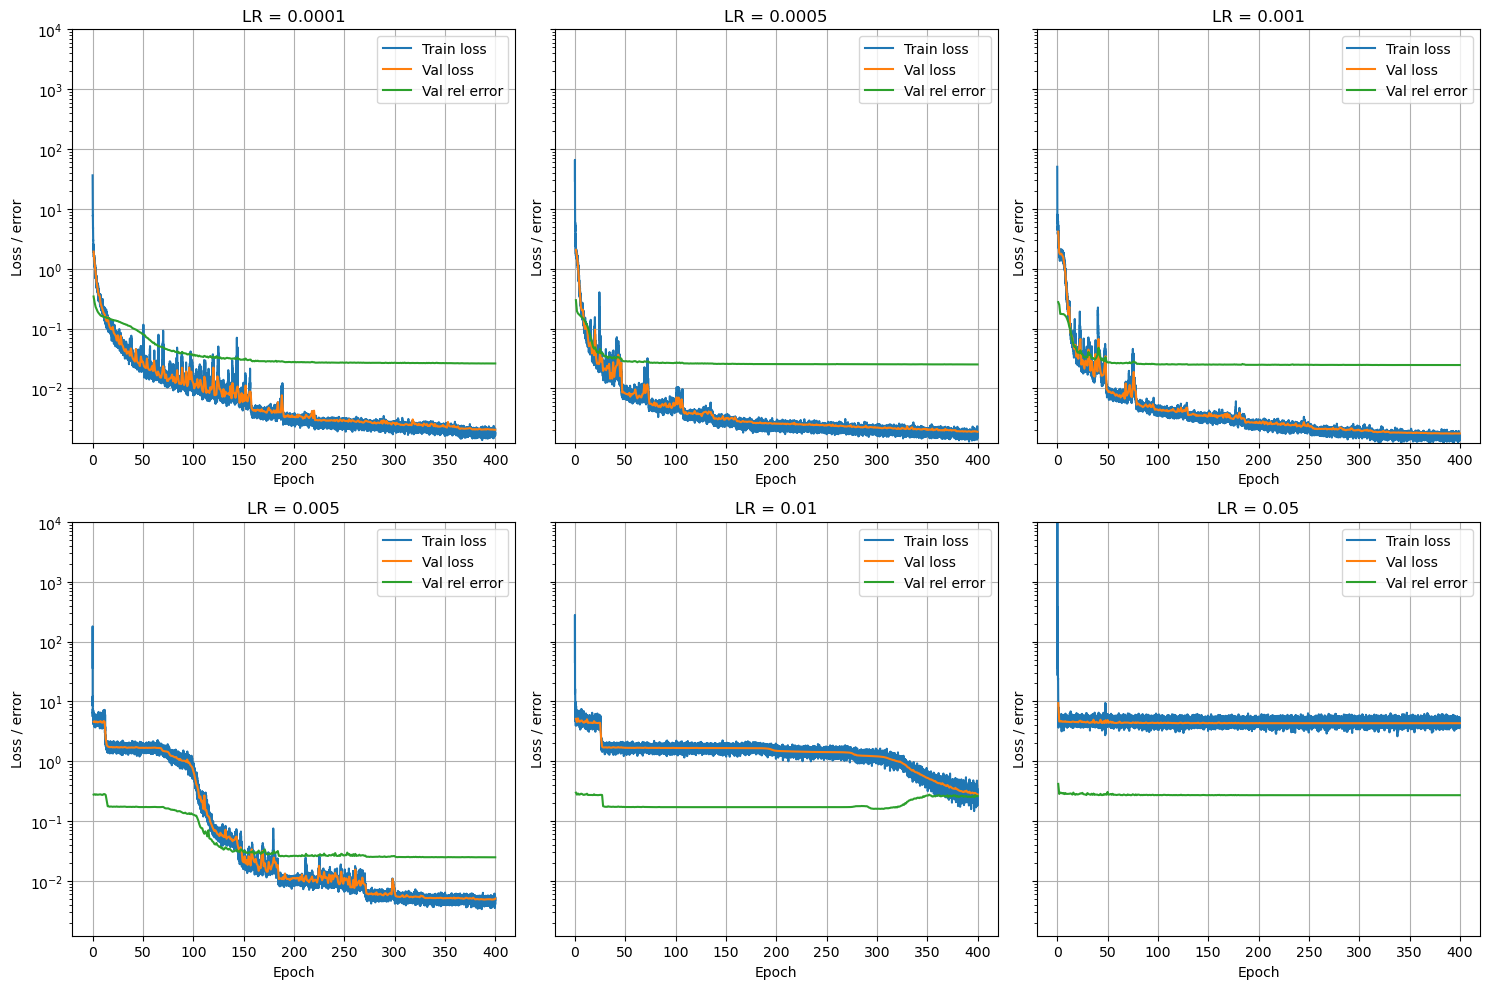

In [19]:
#Plot the graphs changing the learning rate

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

#We fix these values to give a limit to the y-axis of the graphs
y_min = float('inf')
y_max = -float('inf')

################
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400 #FORSW 500!!!!
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
################

for idx, lr in enumerate(lr_values):

    row = idx // 3
    col = idx % 3

    plot(ax[row, col], train_losses_lr[idx], val_losses_lr[idx], val_rel_losses_lr[idx], num_epochs)
    ax[row, col].set_title(f"LR = {lr}")
    y_max = max(y_max, max(np.max(train_losses_lr[idx]), np.max(val_losses_lr[idx]), np.max(val_rel_losses_lr[idx])))
    y_min = min(y_min, min(np.min(train_losses_lr[idx]), np.min(val_losses_lr[idx]), np.min(val_rel_losses_lr[idx])))


for i in range(2):
    for j in range(3):
        ax[i, j].set_ylim(y_min, y_max)


plt.tight_layout()
plt.show()

In [35]:
#Extracting the LR with the highest performance

best_index_lr=np.argmin(final_val_rel_losses_lr)
best_lr = lr_values[best_index_lr]
best_num_epochs=400
print("The best LR is", best_lr,"with", num_epochs, "epochs, with a relative error of", np.min(final_val_rel_losses_lr))

The best LR is 0.001 with 400 epochs, with a relative error of 0.02457439578496493


#### Autoencoder Layers & Latent dimension


In [ ]:
l_values = [1, 2, 3, 4]               #number of layers in the encoder (=decoder)
dim_reduced_list = [32, 64, 128, 256] #output dimension of the encoder (latent dimension)


final_train_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_val_losses_matrix= np.zeros((len(l_values), len(dim_reduced_list)))
final_rel_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_dec_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_solver_matrix = np.zeros((len(l_values), len(dim_reduced_list)))

train_losses_L_dimreduced=[]
val_losses_L_dimreduced=[]
rel_losses_L_dimreduced=[]
losses_enc_solver_L_dimreduced=[]
losses_enc_dec_L_dimreduced=[]

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):

        model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=l),
        best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights=[1,1])

        final_train_losses_matrix[idx_l, idx_dim_reduced] = train_loss_history[-1]
        final_val_losses_matrix[idx_l, idx_dim_reduced] = val_loss_history[-1]
        final_rel_losses_matrix[idx_l, idx_dim_reduced] = val_rel_loss_history[-1]
        final_losses_enc_dec_matrix[idx_l, idx_dim_reduced] = train_loss_enc_dec_history[-1]
        final_losses_enc_solver_matrix[idx_l, idx_dim_reduced] = train_loss_solver_enc_history[-1]


        train_losses_L_dimreduced.append(train_loss_history)
        val_losses_L_dimreduced.append(val_loss_history)
        rel_losses_L_dimreduced.append(val_rel_loss_history)
        losses_enc_dec_L_dimreduced.append(train_loss_enc_dec_history)
        losses_enc_solver_L_dimreduced.append(train_loss_solver_enc_history)
        
        print("Optimization for L=",l,"and latent dimension=", dim_reduced, "finished!")

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
       print(f"Layers = {l}, dim_reduced = {dim_reduced}, Train_loss = {final_train_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, Test_loss = {final_val_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, test_relative_error = {final_rel_losses_matrix[idx_l,idx_dim_reduced ]:.4f}")

Optimization for L= 1 and latent dimension= 32 finished!
Optimization for L= 1 and latent dimension= 64 finished!
Optimization for L= 1 and latent dimension= 128 finished!
Optimization for L= 1 and latent dimension= 256 finished!
Optimization for L= 2 and latent dimension= 32 finished!
Optimization for L= 2 and latent dimension= 64 finished!
Optimization for L= 2 and latent dimension= 128 finished!
Optimization for L= 2 and latent dimension= 256 finished!
Optimization for L= 3 and latent dimension= 32 finished!
Optimization for L= 3 and latent dimension= 64 finished!
Optimization for L= 3 and latent dimension= 128 finished!
Optimization for L= 3 and latent dimension= 256 finished!
Optimization for L= 4 and latent dimension= 32 finished!
Optimization for L= 4 and latent dimension= 64 finished!
Optimization for L= 4 and latent dimension= 128 finished!
Optimization for L= 4 and latent dimension= 256 finished!
Layers = 1, dim_reduced = 32, Train_loss = 0.0059, Test_loss = 0.0065, test_rela

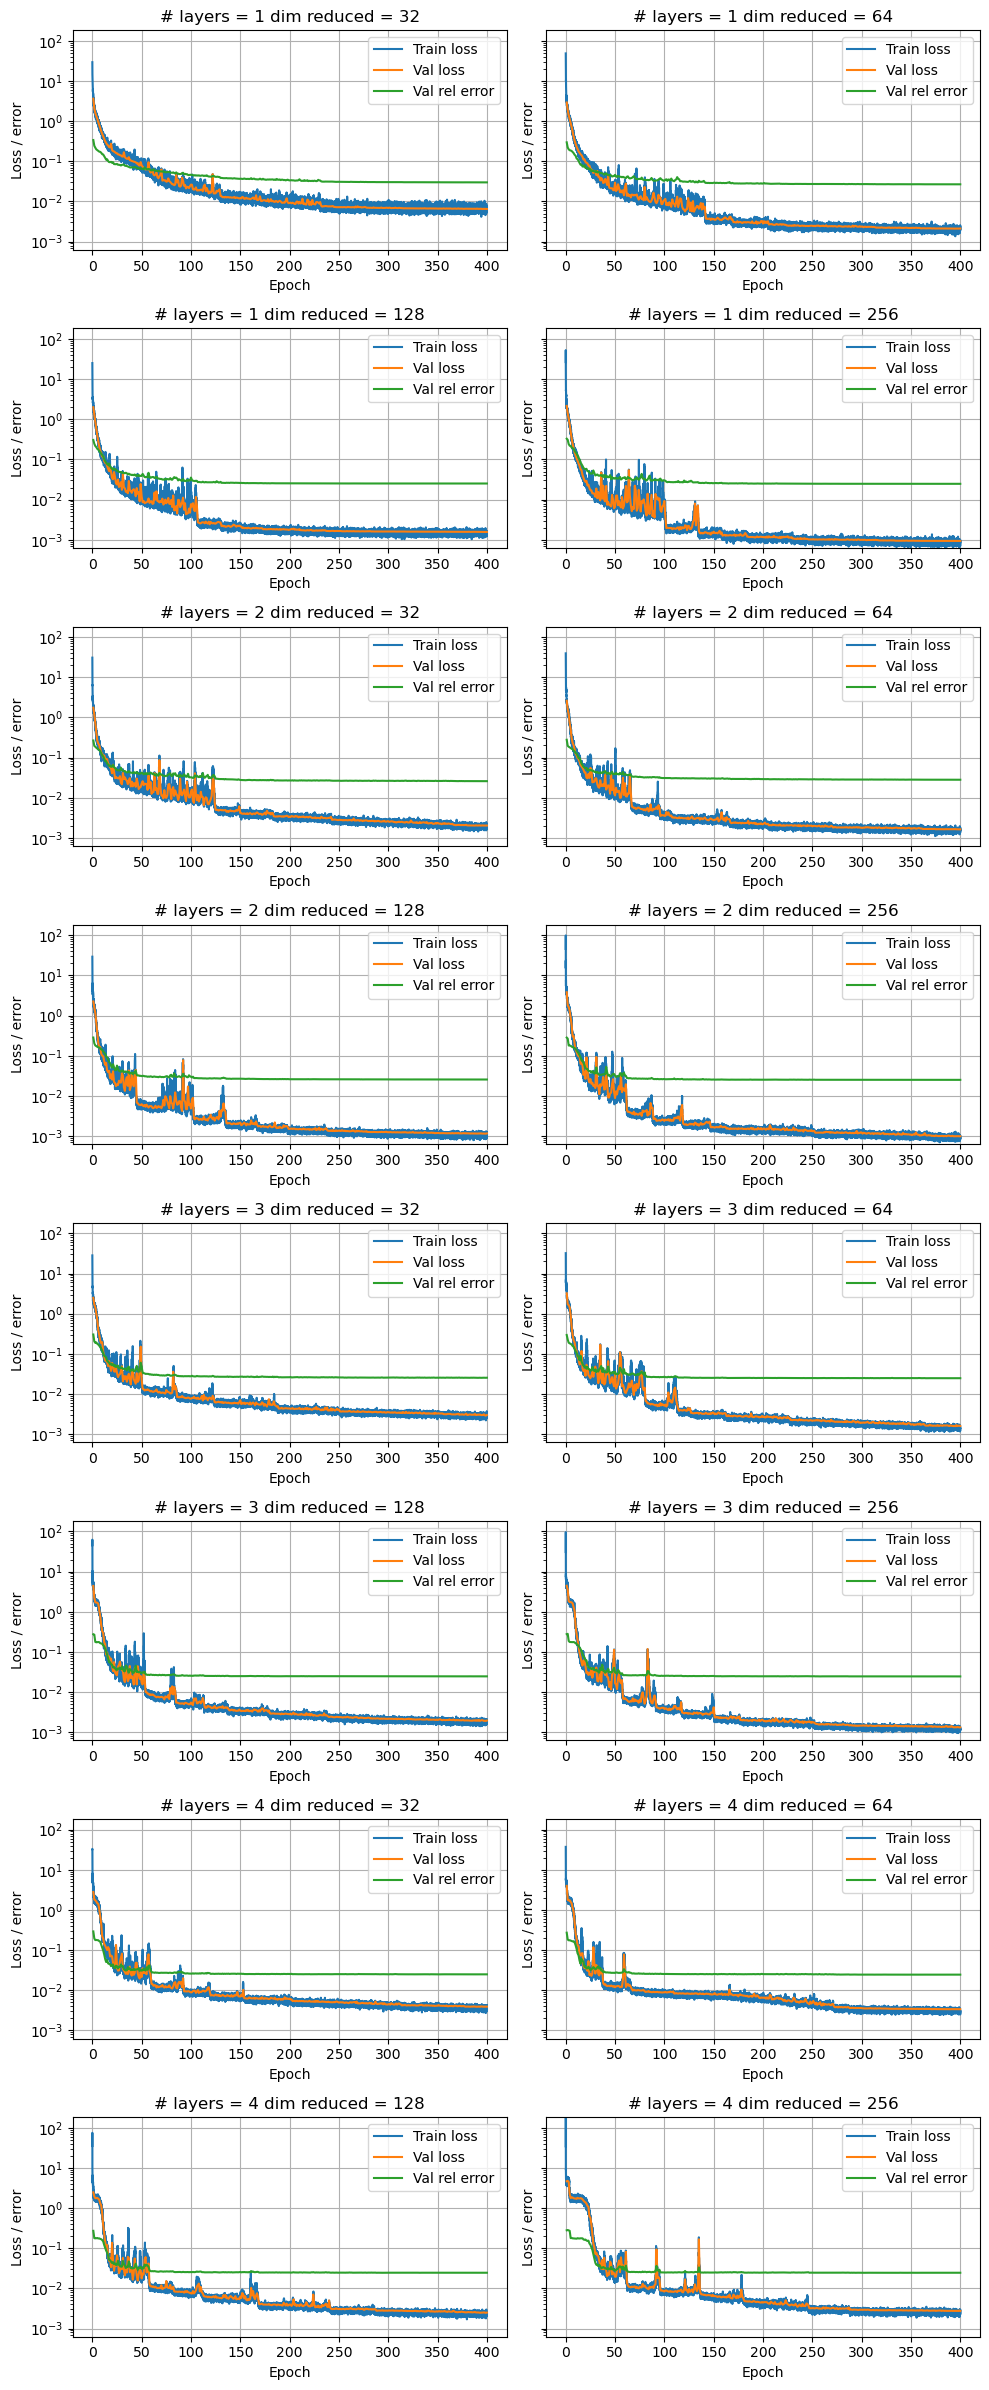

In [27]:
#Plot the graphs

fig, ax = plt.subplots(8, 2, figsize=(10, 24), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
        
        subplot_index = idx_l * len(dim_reduced_list) + idx_dim_reduced
        row = subplot_index // 2
        col = subplot_index % 2

        plot(ax[row, col], train_losses_L_dimreduced[subplot_index], val_losses_L_dimreduced[subplot_index], rel_losses_L_dimreduced[subplot_index], best_num_epochs)
        ax[row, col].set_title(f"# layers = {l} dim reduced = {dim_reduced}", )
        y_max = max(y_max, max(np.max(train_losses_L_dimreduced[subplot_index]), np.max(val_losses_L_dimreduced[subplot_index]), np.max(rel_losses_L_dimreduced[subplot_index])))
        y_min = min(y_min, min(np.min(train_losses_L_dimreduced[subplot_index]), np.min(val_losses_L_dimreduced[subplot_index]), np.min(rel_losses_L_dimreduced[subplot_index])))


for i in range(8):
    for j in range(2):
        ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


In [36]:
#Extracting the best model changing layers in the autoencoder and latent dimension
best_index=np.argmin(final_rel_losses_matrix)

best_row = best_index // 4
best_col = best_index % 4

best_L_enc_dec= l_values[best_row]
best_dim_reduced = dim_reduced_list[best_col]
print(f"best_L_enc_dec = {best_L_enc_dec}, best_dim_reduced = {best_dim_reduced}, with a relative error of", np.min(final_rel_losses_matrix))

best_L_enc_dec = 4, best_dim_reduced = 64, with a relative error of 0.024464612358655685


#### Observe the trend of the two components of the loss for the best model

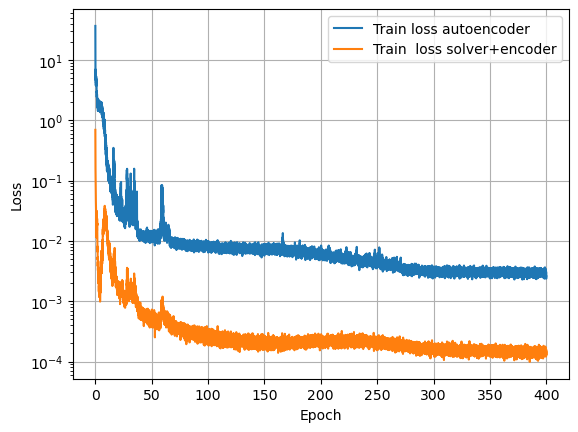

In [29]:
n_train = len(train_loss_history)
t_train = best_num_epochs * np.arange(n_train) / n_train

plt.semilogy(t_train, losses_enc_dec_L_dimreduced[best_index], label="Train loss autoencoder")
plt.semilogy(t_train, losses_enc_solver_L_dimreduced[best_index], label="Train  loss solver+encoder")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True) 

The difference in magnitude between the two losses leads to analyze how their contribute to the global loss should be weighted.
Therefore we perform some optimizations varying their weights in the sum, given the number of epochs, the learning rate, the number of layers in the autoencoder and the latent dimension

#### Weight $w$  ($\mathcal{L}_{autoenc}+w\mathcal{L}_{enc,solv}$)

In [34]:
w_values=[1/100,1/10,1/5,5,10,100]

final_train_losses_w = np.zeros((len(w_values),))
final_val_losses_w= np.zeros((len(w_values),))
final_val_rel_losses_w = np.zeros((len(w_values),))

train_losses_w = []
val_losses_w = []
val_rel_losses_w = []

for idx_w, w_value in enumerate(w_values):

      model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
      SolverPlusMLPAutoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
      best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, weights=[1,w_value])

      final_train_losses_w[idx_w] = train_loss_history[-1]
      final_val_losses_w[idx_w] = val_loss_history[-1]
      final_val_rel_losses_w[idx_w] = val_rel_loss_history[-1]

      train_losses_w.append(train_loss_history)
      val_losses_w.append(val_loss_history)
      val_rel_losses_w.append(val_rel_loss_history)

      print("Optimization for w=",w_value, "finished!")


for idx_w, w_value in enumerate(w_values):
    print(f"Weight value = {w_value}, Train_loss = {final_train_losses_w[idx_w]:.4f}, Test_loss = {final_val_losses_w[idx_w]:.4f}, test_relative_error = {final_val_rel_losses_w[idx_w]:.4f}")

Optimization for w= 0.01 finished!
Optimization for w= 0.1 finished!
Optimization for w= 0.2 finished!
Optimization for w= 5 finished!
Optimization for w= 10 finished!
Optimization for w= 100 finished!
Weight value = 0.01, Train_loss = 0.0026, Test_loss = 0.0032, test_relative_error = 0.0447
Weight value = 0.1, Train_loss = 0.0025, Test_loss = 0.0031, test_relative_error = 0.0248
Weight value = 0.2, Train_loss = 0.0030, Test_loss = 0.0030, test_relative_error = 0.0246
Weight value = 5, Train_loss = 0.0027, Test_loss = 0.0029, test_relative_error = 0.0245
Weight value = 10, Train_loss = 0.0022, Test_loss = 0.0029, test_relative_error = 0.0245
Weight value = 100, Train_loss = 0.0032, Test_loss = 0.0035, test_relative_error = 0.0246


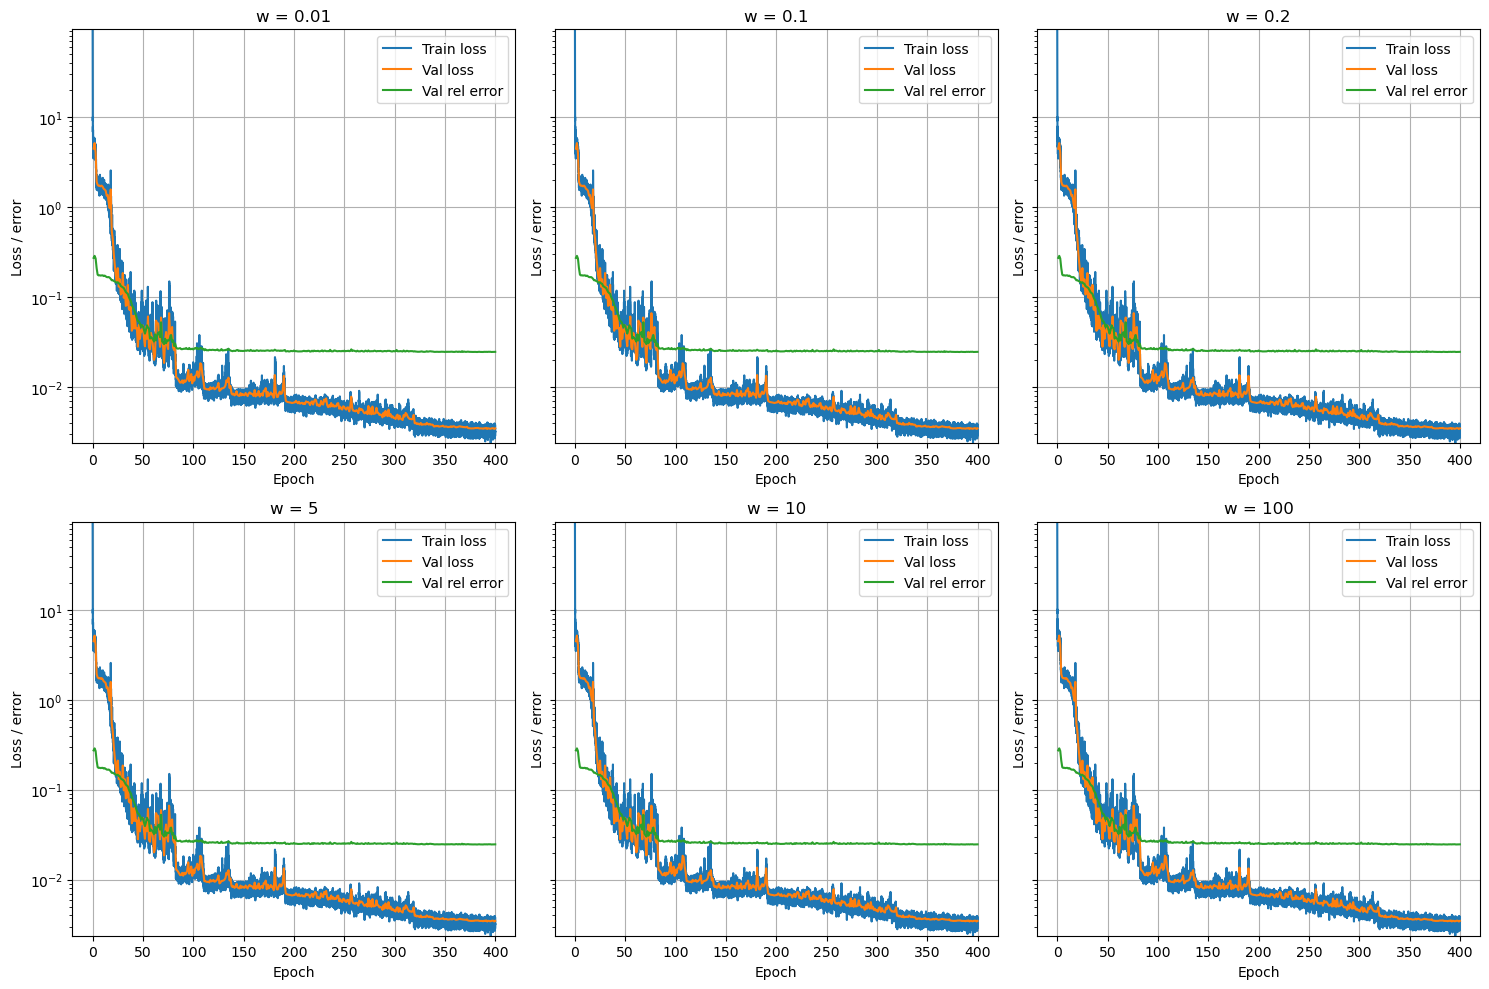

In [37]:
#Plot the graphs changing w

fig, ax = plt.subplots(2, 3 , figsize=(15, 10), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_w, w_value in enumerate(w_values):
      row = idx_w // 3
      col = idx_w % 3

      #plot the graphs
      plot(ax[row,col], train_losses_w[idx], val_losses_w[idx], val_rel_losses_w[idx], best_num_epochs)
      ax[row, col].set_title(f"w = {w_value}")
      y_max = max(y_max, max(np.max(train_losses_w[idx]), np.max(val_losses_w[idx]), np.max(val_rel_losses_w[idx])))
      y_min = min(y_min, min(np.min(train_losses_w[idx]), np.min(val_losses_w[idx]), np.min(val_rel_losses_w[idx])))

for i in range(2):
  for j in range(3):
      ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [39]:
#Extracting the best model changing w
best_index=np.argmin(final_val_rel_losses_w)

best_w=w_values[best_index]
print(f"best w = {best_w}, with a relative error of", np.min(final_val_rel_losses_w))
print("Anyway it is still higher than with w=1")

best w = 5, with a relative error of 0.024471556032315277
Anyway it is still higher than with w=1


#### **Sequential Training**

We investigate how the performance changes applying a sequential training. First, the autoencoder is trained. Then, the solver is trained to reproduce the output of the encoder.

The hyperparameters used in this section are the best hyperparamaters found above:


*   best lr = 0.001
*   best N# epochs = 400
*   best dim_reduced = 
*   best L_enc_dec =



#### Training Autoencoder

In [42]:
def train_autoencoder_epoch(autoencoder, device, train_loader, optimizer, criterion):
    autoencoder.train()

    loss_history = []

    for batch_idx, (data, target) in enumerate(train_loader):


        data=data.to(device) 
        target=target.to(device) 

        output_encoder, output_decoder = autoencoder.forward(target)

        assert output_decoder.shape == target.shape

        target=target*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
        output_decoder=output_decoder*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

        output_decoder_flattened = output_decoder.flatten(1)
        target_fattened = target.flatten(1)

        loss = criterion(output_decoder_flattened, target_fattened)

        optimizer.zero_grad()  # Zero the gradients

        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

    return loss_history


@torch.no_grad()
def validate_autoencoder(autoencoder, device, val_loader, criterion):
    autoencoder.eval()  # Important set model to eval mode (affects dropout, batch norm etc)
    test_loss = 0

    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        output_encoder, output_decoder = autoencoder.forward(target)
        assert output_decoder.shape == target.shape

        target=target*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
        output_decoder=output_decoder*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

        output_flattened = output_decoder.flatten(1)
        target_flattened = target.flatten(1)
        test_loss += criterion(output_flattened, target_flattened).item() * len(data)


    test_loss /= len(val_loader.dataset)

    return test_loss


def run_training(model, train_epoch_func, validate_func, num_epochs, lr, batch_size, device="cuda"):

    train_vel_DataSet = Fluid_Dataset(train_params, train_vel)
    test_vel_DataSet = Fluid_Dataset(test_params, test_vel)

    train_loader = torch.utils.data.DataLoader(
        train_vel_DataSet,
        batch_size=batch_size,
        shuffle=True,  # Can be important for training
        pin_memory=torch.cuda.is_available(),
        drop_last=True,
        # num_workers=2,
        num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        test_vel_DataSet,
        batch_size=batch_size,
    )

    # ===== Model, Optimizer and Criterion =====
    model = model.to(device=device)



    optimizer  = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay = 1e-6
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    criterion = torch.nn.functional.mse_loss
    # ===== Train Model =====
    train_loss_history = []
    val_loss_history = []

    for epoch in range(1, num_epochs + 1):

        train_loss = train_epoch_func(
           model, device, train_loader, optimizer, criterion
        )
        train_loss_history.extend(train_loss)

        val_loss= validate_func(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)

        scheduler.step(val_loss)

    return model, train_loss_history,  val_loss_history

In [43]:
#Training

num_epochs=800 #va molto lento

autoencoder_trained, train_loss_history_autoenc, val_loss_history_autoenc = run_training(
        Autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec), train_autoencoder_epoch, validate_autoencoder, 
        num_epochs, best_lr, batch_size, device)

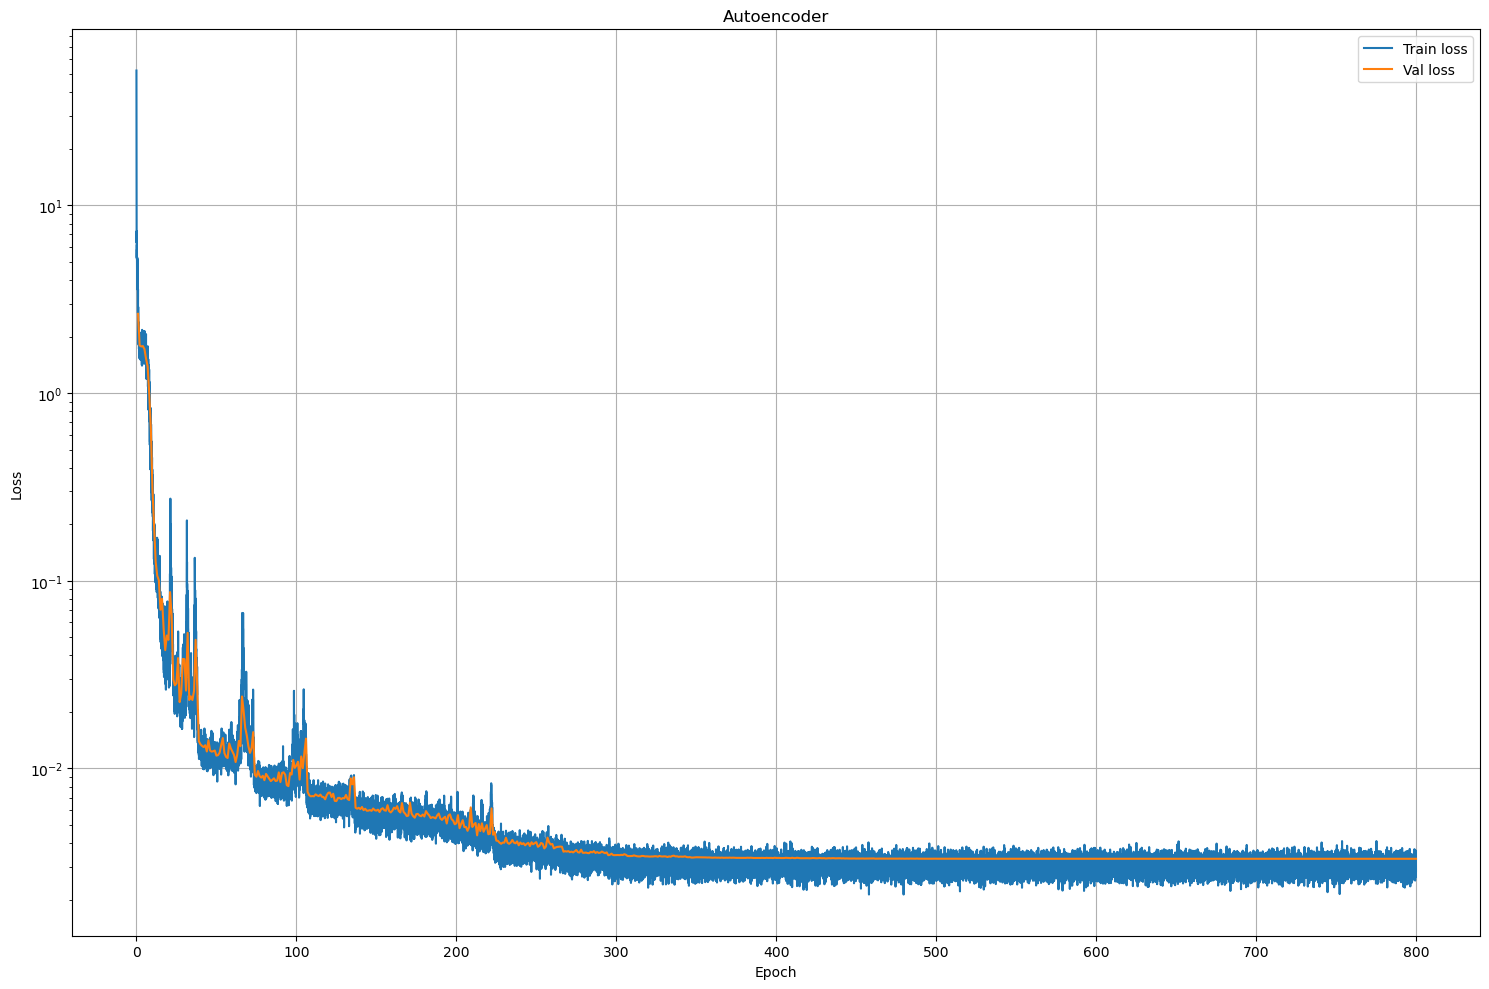

The loss obtained after the optimization is: 0.0033023678697645664


In [44]:
#Plotting results for the Autoencoder

n_train = len(train_loss_history_autoenc)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

fig, ax = plt.subplots(figsize=(15, 10), sharey=True)
ax.semilogy(t_train, train_loss_history_autoenc, label="Train loss")
ax.semilogy(t_val, val_loss_history_autoenc, label="Val loss")

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Autoencoder")
ax.grid(True)
plt.tight_layout()
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_autoenc[-1])

In [45]:
def train_solver_epoch(solver, device, train_loader, optimizer, criterion):
    solver.train()

    loss_history = []

    for batch_idx, (data, target) in enumerate(train_loader):

        data=data.to(device)
        target=target.to(device)

        output_solver = solver.forward(data)

        autoencoder_trained.eval()
        with torch.no_grad():
          output_encoder =  autoencoder_trained.encoder(target) #output of encoder

        loss = criterion(output_encoder, output_solver)

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        loss_history.append(loss.item())

    return loss_history


@torch.no_grad()
def validate_solver(solver, device, val_loader, criterion):
    solver.eval() 

    test_loss = 0

    for data, target in val_loader:

        data, target = data.to(device), target.to(device)
        output_solver = solver.forward(data)

        model_trained.eval()
        output_encoder =  autoencoder_trained.encoder(target)

        test_loss += criterion(output_encoder, output_solver).item() * len(data)

    test_loss /= len(val_loader.dataset)

    return test_loss

In [48]:
#training Solver

num_epochs=600 #?????????

solver_trained, train_loss_history_solver, val_loss_history_solver = run_training(
        Solver(dim_reduced=best_dim_reduced), train_solver_epoch, validate_solver,
        num_epochs, best_lr, batch_size, device)

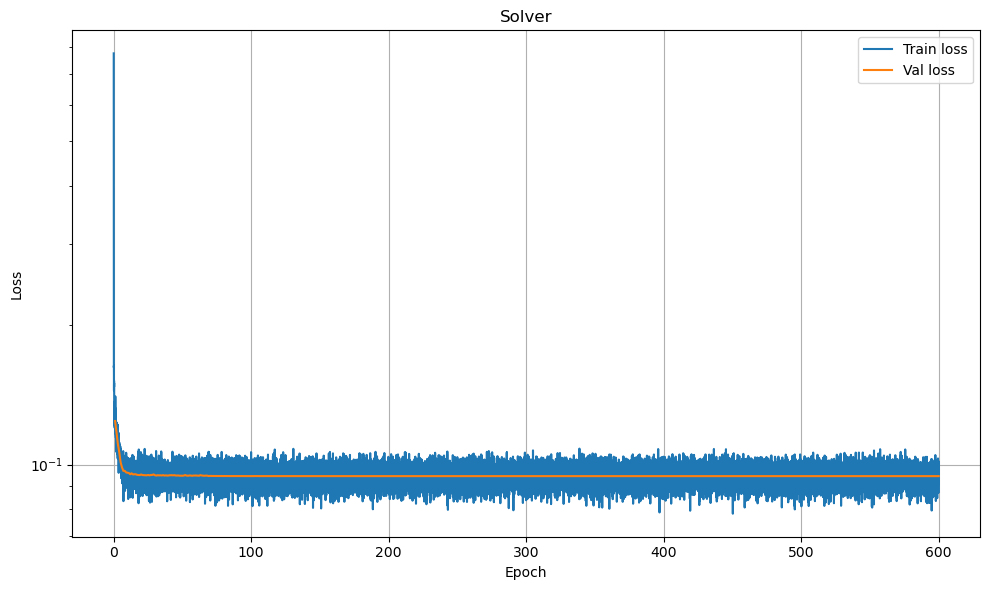

The loss obtained after the optimization is: 0.09442708186614207


In [50]:
#Plotting results for the solver

fig, ax = plt.subplots(figsize=(10, 6))
n_train = len(train_loss_history_solver)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

ax.semilogy(t_train, train_loss_history_solver, label="Train loss")
ax.semilogy(t_val, val_loss_history_solver, label="Val loss")

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title(f"Solver")
ax.grid(True)
plt.tight_layout()
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_solver[-1])

In [53]:
#Performance Evaluation of Sequential Training

solver_trained.eval()
autoencoder_trained.eval()

err_rel=0
with torch.no_grad():
  for (param, vel) in zip(test_params, test_vel):

    param=param.unsqueeze(dim=0)
    param=param.to(device)

    vel=vel.to(device)

    vel_reduced_predict=solver_trained(param)
    vel_predict=autoencoder_trained.decoder(vel_reduced_predict)

    vel_predict=vel_predict.squeeze(dim=0)

    vel_predict=vel_predict*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)
    vel=vel*(1.05*vel_space_max.to(device) - 0.95*vel_space_min.to(device))+0.95*vel_space_min.to(device)

    err_rel+=torch.norm(vel_predict-vel)/torch.norm(vel)

  err_rel=err_rel.item()/len(test_params)
  print("The validation test relative error for the sequential training is: ", err_rel)


The validation test relative error for the sequential training is:  0.16862407586513423


#### **Convolutional Autoencoder**

In [62]:
class SolverPlusConvAutoencoder(torch.nn.Module):
    def __init__(self, activation, pooling, K_comb, L_c, L_l, dim_1=39, dim_2=16, dim_reduced=128, K=256):
        super(SolverPlusConvAutoencoder, self).__init__()

        if L_c == 1:
            dim_post_encoder = 2432
            tuple_dec=[(16,19,8),(39,16)]
        elif L_c == 2:
            dim_post_encoder = 1152
            tuple_dec=[(32,9,4),(19,8),(39,16)]
        elif L_c == 3:
            dim_post_encoder = 512
            tuple_dec=[(64,4,2),(9,4),(19,8),(39,16)]

        self.solver = Solver(L=4, K=K, dim_reduced=dim_reduced, activation=activation)

        self.activation=torch.nn.ReLU if activation=='relu' else torch.nn.GELU
        self.pooling=torch.nn.MaxPool2d if pooling=='max' else torch.nn.AvgPool2d
        initial_h=dim_1
        initial_w=dim_2

        #Encoder
        self.encoder = torch.nn.Sequential(
            *[layer for i in range(L_c) for layer in [
                torch.nn.Conv2d(1 if i == 0 else 2**(i-1)*16, 2**(i)*16, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
                torch.nn.LayerNorm([2**(i)*16,initial_h//(2**i),initial_w//(2**i)]), 
                self.activation(),
                self.pooling(2,2)
            ]],
            torch.nn.Flatten(),
            *[layer for i in range(L_l) for layer in [
                torch.nn.Linear(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1), dim_reduced*(L_l-i)),
                torch.nn.LayerNorm(dim_reduced*(L_l-i)),
                self.activation()
            ]],

        )
        
        #Decoder
        self.decoder = torch.nn.Sequential(
            *[layer for i in range(L_l-1,-1,-1) for layer in [
                torch.nn.Linear(dim_reduced*(L_l-i), dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                torch.nn.LayerNorm(dim_post_encoder if i==0 else dim_reduced*(L_l-i+1)),
                self.activation()
            ]],
            torch.nn.Unflatten(1, tuple_dec[0]),
            *[layer for i in range(L_c-1) for layer in [
                torch.nn.Upsample(size=tuple_dec[i+1]),
                torch.nn.ConvTranspose2d(2**(L_c-i-1)*16, 2**(L_c-i-2)*16, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
                torch.nn.LayerNorm([2**(L_c-i-2)*16,*tuple_dec[i+1]]), 
                self.activation(),
            ]],
            torch.nn.Upsample(size=tuple_dec[-1]),
            torch.nn.ConvTranspose2d(16, 1, kernel_size=K_comb[0], stride=K_comb[1], padding=K_comb[2]),
            # torch.nn.Sigmoid()
        )



    def forward(self, par, out):
        output_solver = self.solver(par)  # (batch_size, dim_reduced)

        out_squeezed = out.unsqueeze(1) #(batch_size x 39 x 16) -> #(batch_size x 1 x 39 x 16)

        output_encoder = self.encoder(out_squeezed)  # (batch_size, dim_reduced)

        output_decoder = self.decoder(output_encoder) # (batch_siz, 1, dim_1, dim_2)
        output_decoder=output_decoder.squeeze(1)  # (batch_siz, dim_1, dim_2)

        return output_solver, output_encoder, output_decoder

    def predict(self, par):
        output_solver = self.solver(par)  # (dim_1_reduced * dim_2_reduced)
        output_predict = self.decoder(output_solver)  # (batch_size, 1, dim_1, dim_2)
        output_predict=output_predict.squeeze(1)
        return output_predict

In [ ]:
activation="gelu"
pooling="avg"
K_comb=[5,1,2]
lr=0.001
num_epochs=400 #FORSE RIFARE CON 500????
dim_reduced=128

Lc_Ll_list=[(2,2),(2,3),(3,2)]

final_train_losses_conv = np.zeros((len(Lc_Ll_list),))
final_val_losses_conv= np.zeros((len(Lc_Ll_list),))
final_val_rel_losses_conv = np.zeros((len(Lc_Ll_list),))

train_losses_conv = []
val_losses_conv = []
val_rel_losses_conv = []

for idx_conv, el in enumerate(Lc_Ll_list):
    L_c=el[0]
    L_l=el[1]
    model_trained, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusConvAutoencoder(activation, pooling, K_comb, L_c, L_l,  dim_reduced=dim_reduced), num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device)

    final_train_losses_conv[idx_conv] = train_loss_history[-1]
    final_val_losses_conv[idx_conv] = val_loss_history[-1]
    final_val_rel_losses_conv[idx_conv] = val_rel_loss_history[-1]

    train_losses_conv.append(train_loss_history)
    val_losses_conv.append(val_loss_history)
    val_rel_losses_conv.append(val_rel_loss_history)

    print("Optimization for (L_c, L_l)=", el, "finished!")

for idx_conv, el in enumerate(Lc_Ll_list):
    print(f"(L_c, L_l) = {el}, Train_loss = {final_train_losses_conv[idx_conv]:.4f}, Test_loss = {final_val_losses_conv[idx_conv]:.4f}, test_relative_error = {final_val_rel_losses_conv[idx_conv]:.4f}")

Optimization for (L_c, L_l)= (2, 2) finished!
Optimization for (L_c, L_l)= (2, 3) finished!
Optimization for (L_c, L_l)= (3, 2) finished!
(L_c, L_l) = (2, 2), Train_loss = 0.0064, Test_loss = 0.0065, test_relative_error = 0.0259
(L_c, L_l) = (2, 3), Train_loss = 0.0066, Test_loss = 0.0062, test_relative_error = 0.0258
(L_c, L_l) = (3, 2), Train_loss = 0.0098, Test_loss = 0.0118, test_relative_error = 0.0271


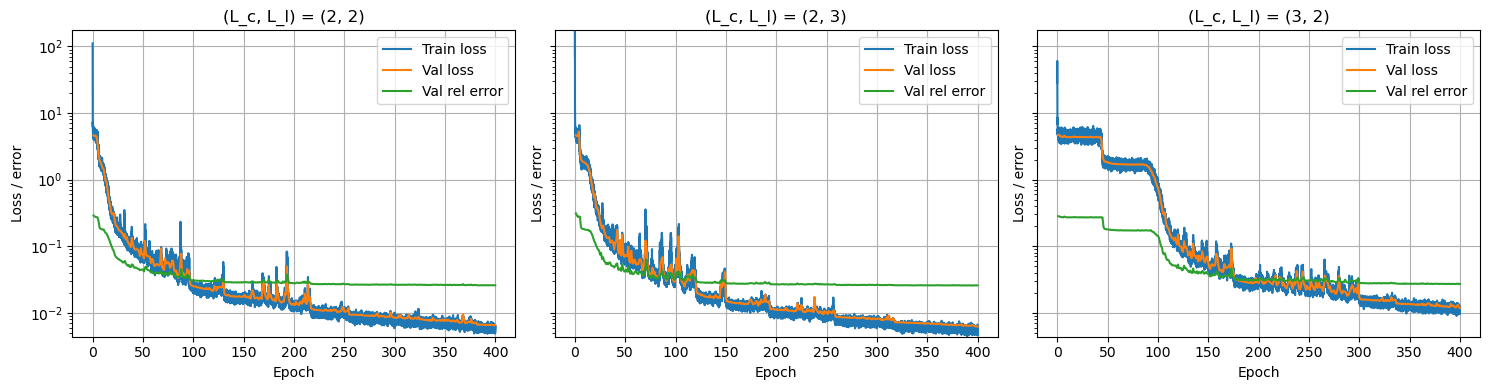

In [68]:
#Plot the graphs using a convolutional autoencoder

fig, ax = plt.subplots(1, 3 , figsize=(15, 4), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_conv, el in enumerate(Lc_Ll_list):
      
      plot(ax[idx_conv], train_losses_conv[idx_conv], val_losses_conv[idx_conv], val_rel_losses_conv[idx_conv], num_epochs)
      ax[idx_conv].set_title(f"(L_c, L_l) = {el}")
      y_max = max(y_max, max(np.max(train_losses_conv[idx_conv]), np.max(val_losses_conv[idx_conv]), np.max(val_rel_losses_conv[idx_conv])))
      y_min = min(y_min, min(np.min(train_losses_conv[idx_conv]), np.min(val_losses_conv[idx_conv]), np.min(val_rel_losses_conv[idx_conv])))

for i in range(3):
      ax[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

#### **Cross-validation over the best model**

In [71]:
def build_k_indices(N, k_fold):
    """build k indices for k-fold.

    Args:
        y:      shape=(N,)
        k_fold: K in K-fold, i.e. the fold num

    Returns:
        A 2D array of shape=(k_fold, N/k_fold) that indicates the data indices for each fold
    """
    interval = int(N / k_fold) #number of data per fold-set
    indices = np.random.permutation(N) #permutation of array from 0 to num_row
    k_indices = [indices[k * interval : (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)



k_fold = 5
k_indices=build_k_indices(len(params), k_fold)

train_loss_crossval=[]
val_loss_crossval=[]
val_rel_loss_crossval=[]

for k in range (0, k_fold):
    test_vel_k=solutions["velocity"][k_indices[k,:]]
    train_params_k=params[np.delete(k_indices, k, axis=0).ravel()]
    train_vel_k=solutions["velocity"][np.delete(k_indices, k, axis=0).ravel()]
    test_params_k=params[k_indices[k]]

    test_vel_k=(test_vel_k - vel_space_min.to('cpu')*0.95) / (1.05*vel_space_max.to('cpu') - 0.95*vel_space_min.to('cpu'))
    train_vel_k=(train_vel_k - vel_space_min.to('cpu')*0.95) / (1.05*vel_space_max.to('cpu') - 0.95*vel_space_min.to('cpu'))
    train_params_k=(train_params_k-min_params)/(max_params-min_params)
    test_params_k=(test_params_k-min_params)/(max_params-min_params)

    model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(activation="gelu", L_enc_dec=best_L_enc_dec, dim_reduced=best_dim_reduced),
        best_num_epochs, best_lr, batch_size, train_params_k, train_vel_k, test_params_k, test_vel_k, device, weights=[1,1])

    train_loss_crossval.append(train_loss_history[-1])
    val_loss_crossval.append(val_loss_history[-1])
    val_rel_loss_crossval.append(val_rel_loss_history[-1])
    print("Optimization for optimization", k+1, "over", k_fold, "finished! Relative error:", val_rel_loss_history[-1])

Optimization for optimization 0 over 5 finished! Relative error: 0.025079824297856063
Optimization for optimization 1 over 5 finished! Relative error: 0.024643169267055315
Optimization for optimization 2 over 5 finished! Relative error: 0.024439164728690416
Optimization for optimization 3 over 5 finished! Relative error: 0.025455784186338766
Optimization for optimization 4 over 5 finished! Relative error: 0.024989259319427685


In [72]:
#Computing the mean over the k_fold

mean_train_loss=sum(train_loss_crossval)/k_fold
mean_val_loss=sum(val_loss_crossval)/k_fold
mean_val_rel_loss=sum(val_rel_loss_crossval)/k_fold

print("The mean training loss is: ", mean_train_loss)
print("The mean test loss is: ", mean_val_loss)
print("The mean validation relative error is: ", mean_val_rel_loss)

#Final best model
best_model=model_trained

The mean training loss is:  0.0029494253918528556
The mean test loss is:  0.003293166960326907
The mean validation relative error is:  0.024921440359873648


In [80]:
#Useful functions to create data to visualize the fields in 3D (e.g. ParaView)

def read_vtk(filename):
    """Read .vtk file and return the polydata"""

    fn_dir, fn_ext = os.path.splitext(filename)

    if fn_ext == '.vtk':
        reader = vtk.vtkPolyDataReader()
    elif fn_ext == '.vtp':
        reader = vtk.vtkXMLPolyDataReader()
    elif fn_ext == '.stl':
        reader = vtk.vtkSTLReader()
    elif fn_ext == '.obj':
        reader = vtk.vtkOBJReader()
    elif fn_ext == '.vtu':
        reader = vtk.vtkXMLUnstructuredGridReader()
    elif fn_ext == '.pvtu':
        reader = vtk.vtkXMLPUnstructuredGridReader()
    else:
        raise ValueError(F"File extension {fn_ext} not supported")

    reader.SetFileName(filename)
    reader.Update(0)
    mesh = reader.GetOutput()

    return mesh

def write_vtk(mesh, fn):
    """ Write a mesh (vtk polydata or unstructured grid) to disk """

    _, extension = os.path.splitext(fn)

    if extension == '.vtk':
        writer = vtk.vtkPolyDataWriter()
    elif extension == '.stl':
        writer = vtk.vtkSTLWriter()
    elif extension == '.vtp':
        writer = vtk.vtkXMLPolyDataWriter()
    elif extension == '.vtu':
        writer = vtk.vtkXMLUnstructuredGridWriter()
    elif extension == '.obj':
        writer = vtk.vtkOBJWriter()
    else:
        raise ValueError(f"Unrecognized extension {extension}")

    writer.SetInputData(mesh)
    writer.SetFileName(fn)
    writer.Update(0)
    writer.Write()

    return

def add_array(mesh, array, name):
    """Add numpy array as new field to a vtk file"""

    new_array = numpy_to_vtk(array)
    new_array.SetName(name)
    mesh.GetPointData().AddArray(new_array)

    return mesh

def compute_matching_idxs():
    """Compute correspondences bewteen indices on the .vtu and on the .mesh file for plotting"""

    mesh = read_vtk(os.path.join(DATASET_PATH, 'geometries', 'bif_sym_alpha50_h0.10_ref.vtu'))
    points = vtk_to_numpy(mesh.GetPoints().GetData())

    mesh_2 = meshio.read(os.path.join(DATASET_PATH, 'geometries','bif_sym_alpha50_h0.10.mesh'))
    points_2 = mesh_2.points

    dist = cdist(mesh_2.points, points, metric='euclidean')

    idxs = np.argmin(dist, axis=0)

    return idxs


def visualize_solution(field_array, fields=None, step_t=10):
    """ Export the solution corresponding to the n-th snapshot (every step_t steps) to a .vtu file."""

    if fields is None:
        fields = {'velocity': 3, 'pressure': 1}  # fields and corresponding dimensions

    os.makedirs('solutions', exist_ok=True)

    idxs = compute_matching_idxs()

    mesh = read_vtk(os.path.join(DATASET_PATH, 'geometries', 'bif_sym_alpha50_h0.10.vtu'))

    fom_solution = dict()
    for field in fields:
        # print(f"Processing field {field} - Dimension: {fields[field]}")
        cur_idxs = np.hstack([idxs + k * (Nh_space[field]//fields[field]) for k in range(fields[field])])
        fom_solution[field] = expand(field_array, basis_space[field], basis_time[field])[cur_idxs]

    for cnt_t in range(0, Nh_time['velocity'], step_t):
        # print(f"\nProcessing timestep {cnt_t} of {Nh_time['velocity']}")
        for field in fields:
            cur_fom_solution = np.reshape(fom_solution[field][:, cnt_t], (fields[field], -1)).T
            mesh = add_array(mesh, cur_fom_solution, field)

        # write_vtk(mesh, os.path.join('solutions', f"solution_{n}_{cnt_t}" + '.vtu'))
        write_vtk(mesh, os.path.join('solutions', f"solution_{cnt_t}" + '.vtu'))

    return

The relative error between the ground truth and the prediction is: 1.282973401248455 %


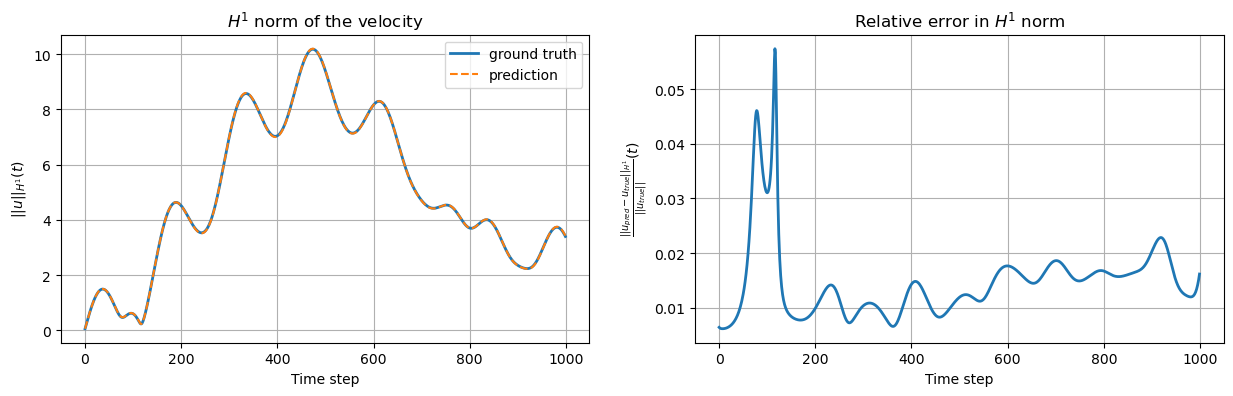

In [111]:
best_model.eval()

chosen_index=np.random.randint(0, len(test_params))
input_tensor = test_params[chosen_index,:]
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    predicted_vel = model_trained.predict(input_tensor)
predicted_vel=predicted_vel[0]
predicted_vel=predicted_vel.to("cpu")
predicted_vel=predicted_vel*(1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))+0.95*vel_space_min.to("cpu")

true_vel=test_vel[chosen_index]*(1.05*vel_space_max.to("cpu") - 0.95*vel_space_min.to("cpu"))+0.95*vel_space_min.to("cpu")
rel_err_reduced=(torch.norm((predicted_vel-true_vel).view(-1)/torch.norm(true_vel.view(-1,)))).item()
print("The relative error between the ground truth and the prediction is:", rel_err_reduced*100,"%")

H1_space_norm_predict = np.linalg.norm(predicted_vel.numpy() @ basis_time["velocity"].T, axis=0)
H1_space_norm_true = np.linalg.norm(true_vel.numpy() @ basis_time["velocity"].T, axis=0)
H1_space_norm_diff = np.linalg.norm((true_vel-predicted_vel).numpy() @ basis_time["velocity"].T, axis=0)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(np.arange(len(H1_space_norm_true)),H1_space_norm_true,label="ground truth", linewidth=2)
axs[0].plot(np.arange(len(H1_space_norm_predict)),H1_space_norm_predict,label="prediction", linestyle='--')
axs[0].legend()
axs[0].set_xlabel("Time step")
axs[0].set_ylabel(r'$||u||_{H^1}(t)$')
axs[0].set_title(r'$H^1$ norm of the velocity')
axs[0].grid(True)

axs[1].plot(np.arange(len(H1_space_norm_true)),H1_space_norm_diff/H1_space_norm_true, linewidth=2)
axs[1].set_xlabel("Time step")
axs[1].set_ylabel(r'$\frac{||u_{pred}-u_{true}||_{H^1}}{||u_{true}||}(t)$')
axs[1].set_title(r'Relative error in $H^1$ norm')
axs[1].grid(True)

plt.show()

#Export data to visualize the field in 3D (e.g. ParaView)
visualize_solution(predicted_vel.numpy() ,fields={'velocity': 3}, step_t=5)